# Final Project

## Gathering Data + Setup

Using device: cpu
Train Epoch: 1 [0/60000 (0%)]	Loss: 134.102478
Train Epoch: 1 [1600/60000 (3%)]	Loss: 50.540306
Train Epoch: 1 [3200/60000 (5%)]	Loss: 48.858086
Train Epoch: 1 [4800/60000 (8%)]	Loss: 38.731983
Train Epoch: 1 [6400/60000 (11%)]	Loss: 46.308147
Train Epoch: 1 [8000/60000 (13%)]	Loss: 46.244099
Train Epoch: 1 [9600/60000 (16%)]	Loss: 37.493404
Train Epoch: 1 [11200/60000 (19%)]	Loss: 39.453953
Train Epoch: 1 [12800/60000 (21%)]	Loss: 39.718189
Train Epoch: 1 [14400/60000 (24%)]	Loss: 38.995853
Train Epoch: 1 [16000/60000 (27%)]	Loss: 39.571777
Train Epoch: 1 [17600/60000 (29%)]	Loss: 36.086452
Train Epoch: 1 [19200/60000 (32%)]	Loss: 35.159489
Train Epoch: 1 [20800/60000 (35%)]	Loss: 30.822168
Train Epoch: 1 [22400/60000 (37%)]	Loss: 35.847569
Train Epoch: 1 [24000/60000 (40%)]	Loss: 29.287840
Train Epoch: 1 [25600/60000 (43%)]	Loss: 28.343134
Train Epoch: 1 [27200/60000 (45%)]	Loss: 30.354271
Train Epoch: 1 [28800/60000 (48%)]	Loss: 26.862797
Train Epoch: 1 [30400/6000

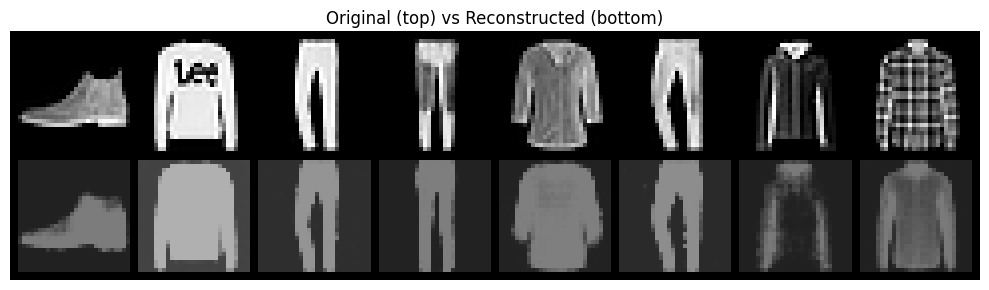

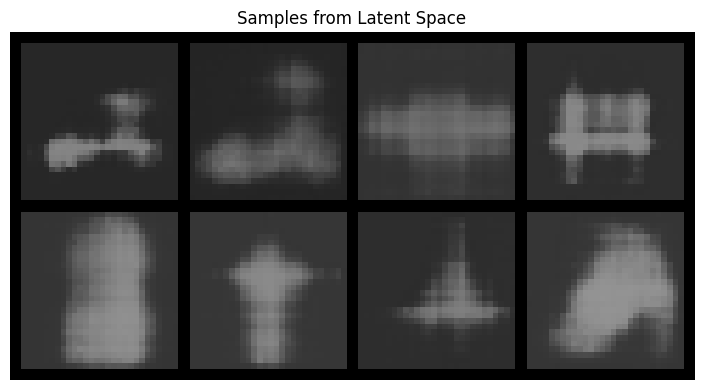

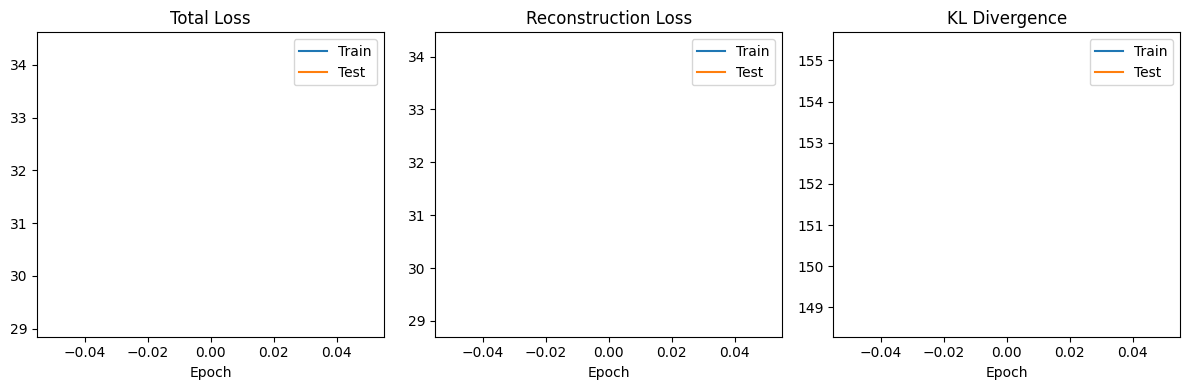

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.utils import make_grid

OMEGA_0 = 30.0  
HIDDEN_SIZE = 128
N_HIDDEN_LAYERS = 3
IMAGE_CHANNELS = 1
Z_DIM = 64
BATCH_SIZE = 100 
LEARNING_RATE = 1e-4
EPOCHS = 1     
NUM_BANDS = 8 

def positional_encoding(coords, num_bands=NUM_BANDS):
    """Apply positional encoding to the input coordinates."""
    pos_enc = [coords]
    for i in range(num_bands):
        freq = 2.0 ** i
        pos_enc.append(torch.sin(coords * freq * np.pi))
        pos_enc.append(torch.cos(coords * freq * np.pi))
    return torch.cat(pos_enc, dim=-1)

def get_mgrid(sidelen, dim=2, num_bands=NUM_BANDS):
    """Get a meshgrid of coordinates with positional encoding."""
    if isinstance(sidelen, int):
        sidelen = dim * (sidelen,)
    coords = [torch.linspace(-1, 1, s) for s in sidelen]
    mesh_coords = torch.meshgrid(*coords, indexing='ij')  
    coords = torch.stack(mesh_coords, dim=-1).reshape(-1, dim)
    return positional_encoding(coords, num_bands)

class SineLayer(nn.Module):
    """Sine activation with omega_0 frequency factor."""
    def __init__(self, in_features, out_features, omega_0=OMEGA_0):
        super().__init__()
        self.omega_0 = omega_0
        self.in_features = in_features
        self.out_features = out_features
    
    def forward(self, input, W, b):
        return torch.sin(self.omega_0 * F.linear(input, W, b))

class SIREN(nn.Module):
    """SIREN network that can use dynamically generated weights."""
    def __init__(self, input_dim=2+2*2*NUM_BANDS, hidden_dim=HIDDEN_SIZE, 
                hidden_layers=N_HIDDEN_LAYERS, output_dim=IMAGE_CHANNELS):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.hidden_layers = hidden_layers
        self.output_dim = output_dim
        
        # Calculate sizes for weight partitioning
        self.weight_sizes = self.calc_weight_sizes()
        self.total_weights = sum(self.weight_sizes)
        
        # Create layers
        self.first_layer = SineLayer(input_dim, hidden_dim, omega_0=30.0)
        self.hidden_layers_list = nn.ModuleList([
            SineLayer(hidden_dim, hidden_dim) for _ in range(hidden_layers)
        ])
    
    def calc_weight_sizes(self):
        """Calculate sizes of each weight tensor for partitioning."""
        sizes = []
        # First layer weights and biases
        sizes.append(self.input_dim * self.hidden_dim)  # W1
        sizes.append(self.hidden_dim)  # b1
        
        # Hidden layers weights and biases
        for _ in range(self.hidden_layers):
            sizes.append(self.hidden_dim * self.hidden_dim)  # W
            sizes.append(self.hidden_dim)  # b
        
        # Output layer weights and biases
        sizes.append(self.hidden_dim * self.output_dim)  # W_out
        sizes.append(self.output_dim)  # b_out
        
        return sizes
    
    @staticmethod
    def calc_total_weights(input_dim, hidden_dim, hidden_layers, output_dim):
        """Calculate total number of weights needed for the network."""
        total = input_dim * hidden_dim + hidden_dim  # First layer
        total += hidden_layers * (hidden_dim * hidden_dim + hidden_dim)  # Hidden layers
        total += hidden_dim * output_dim + output_dim  # Output layer
        return total
    
    def forward(self, coords, weights):
        """Forward pass using dynamically generated weights."""
        weight_parts = []
        start_idx = 0
        for size in self.weight_sizes:
            weight_parts.append(weights[:, start_idx:start_idx+size])
            start_idx += size
        
        # Apply first layer
        idx = 0
        W1 = weight_parts[idx].view(-1, self.hidden_dim, self.input_dim)
        idx += 1
        b1 = weight_parts[idx]
        idx += 1
        
        # Process each example in the batch separately
        batch_size = weights.shape[0]
        outputs = []
        
        for i in range(batch_size):
            x = self.first_layer(coords, W1[i], b1[i])
            
            # Apply hidden layers
            for layer_idx, layer in enumerate(self.hidden_layers_list):
                W = weight_parts[idx + layer_idx*2].view(-1, self.hidden_dim, self.hidden_dim)[i]
                b = weight_parts[idx + layer_idx*2 + 1][i]
                x = layer(x, W, b)
            
            # Apply final layer
            final_idx = idx + len(self.hidden_layers_list) * 2
            W_final = weight_parts[final_idx].view(-1, self.output_dim, self.hidden_dim)[i]
            b_final = weight_parts[final_idx + 1][i]
            x = F.linear(x, W_final, b_final)
            x = torch.sigmoid(x)  # Apply sigmoid for image pixel values
            
            outputs.append(x)
        
        # Stack all batch outputs
        return torch.stack(outputs)

class VAE(nn.Module):
    def __init__(self, z_dim=Z_DIM, siren_config=None):
        super().__init__()
        self.z_dim = z_dim
        
        # Default SIREN config
        self.siren_config = {
            'input_dim': 2 + 2*2*NUM_BANDS,  # 2D coords + positional encoding
            'hidden_dim': HIDDEN_SIZE,       
            'hidden_layers': N_HIDDEN_LAYERS,       
            'output_dim': IMAGE_CHANNELS
        }
        
        # Update config if provided
        if siren_config is not None:
            self.siren_config.update(siren_config)
        
        # Create the SIREN to use for decoding
        self.siren = SIREN(
            input_dim=self.siren_config['input_dim'],
            hidden_dim=self.siren_config['hidden_dim'],
            hidden_layers=self.siren_config['hidden_layers'],
            output_dim=self.siren_config['output_dim']
        )
        
        # Encoder network
        self.encoder = nn.Sequential(
            nn.Conv2d(IMAGE_CHANNELS, 32, 4, stride=2, padding=1),  # 28x28 -> 14x14
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),              # 14x14 -> 7x7
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),             # 7x7 -> 7x7
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Latent space parameters
        self.fc_mu = nn.Linear(512, z_dim)
        self.fc_logvar = nn.Linear(512, z_dim)
        
        # Calculate total weights needed for SIREN
        total_weights = SIREN.calc_total_weights(
            input_dim=self.siren_config['input_dim'],
            hidden_dim=self.siren_config['hidden_dim'],
            hidden_layers=self.siren_config['hidden_layers'],
            output_dim=self.siren_config['output_dim']
        )
        
        # Decoder network (produces weights for SIREN)
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, total_weights) 
        )
    
    def encode(self, x):
        """Encode input images to latent space parameters."""
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        """Reparameterization trick to sample from latent space."""
        logvar = torch.clamp(logvar, -4, 4)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        """Decode latent vectors to SIREN weights."""
        raw_weights = self.decoder(z)
        
        # Split and scale weights for different SIREN layers
        weights_list = []
        start_idx = 0
        
        # First layer weights - needs uniform(-1/in_dim, 1/in_dim)
        in_dim = self.siren_config['input_dim']
        first_w_size = in_dim * self.siren_config['hidden_dim']
        first_b_size = self.siren_config['hidden_dim']
        
        first_w = raw_weights[:, start_idx:start_idx+first_w_size].view(-1, self.siren_config['hidden_dim'], in_dim)
        start_idx += first_w_size
        first_w = torch.tanh(first_w) * (1.0/in_dim)  # Scale to proper range
        weights_list.append(first_w.reshape(-1, first_w_size))
        
        first_b = raw_weights[:, start_idx:start_idx+first_b_size]
        start_idx += first_b_size
        first_b = torch.tanh(first_b) * (1.0/in_dim)  # Scale to proper range
        weights_list.append(first_b)
        
        # Hidden layers - needs scaled by sqrt(6/hidden_dim)/omega
        hidden_dim = self.siren_config['hidden_dim']
        hidden_omega = 30.0
        scale_factor = np.sqrt(6/hidden_dim)/hidden_omega
        
        for _ in range(self.siren_config['hidden_layers']):
            hidden_w_size = hidden_dim * hidden_dim
            hidden_w = raw_weights[:, start_idx:start_idx+hidden_w_size].view(-1, hidden_dim, hidden_dim)
            start_idx += hidden_w_size
            hidden_w = torch.tanh(hidden_w) * scale_factor
            weights_list.append(hidden_w.reshape(-1, hidden_w_size))
            
            hidden_b_size = hidden_dim
            hidden_b = raw_weights[:, start_idx:start_idx+hidden_b_size]
            start_idx += hidden_b_size
            hidden_b = torch.tanh(hidden_b) * scale_factor
            weights_list.append(hidden_b)
        
        # Output layer
        out_dim = self.siren_config['output_dim']
        out_w_size = hidden_dim * out_dim
        out_w = raw_weights[:, start_idx:start_idx+out_w_size].view(-1, out_dim, hidden_dim)
        start_idx += out_w_size
        out_w = torch.tanh(out_w) * scale_factor
        weights_list.append(out_w.reshape(-1, out_w_size))
        
        out_b_size = out_dim
        out_b = raw_weights[:, start_idx:start_idx+out_b_size]
        out_b = torch.tanh(out_b)  # Range (-1, 1) is fine for output bias
        weights_list.append(out_b)
        
        # Concatenate all scaled weights
        return torch.cat(weights_list, dim=1)
    
    def forward(self, x, coords=None, img_size=28):
        """Forward pass through the VAE."""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        siren_weights = self.decode(z)
        
        # Generate coordinate grid if not provided
        if coords is None:
            coords = get_mgrid(img_size, dim=2, num_bands=NUM_BANDS).to(x.device)
        
        # Get image reconstruction from SIREN
        batch_recons = self.siren(coords, siren_weights)
        
        # Reshape to proper image format [B, C, H, W]
        batch_recons = batch_recons.reshape(z.size(0), IMAGE_CHANNELS, img_size, img_size)
        
        return batch_recons, mu, logvar, siren_weights

def loss_function(recon_x, x, mu, logvar, kld_weight=0.001):
    """VAE loss function combining reconstruction and KL divergence."""
    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    
    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Total loss
    return recon_loss + kld_weight * kl_loss, recon_loss, kl_loss

def train_model(model, train_loader, optimizer, device, epoch, img_size=28, kld_weight=0.001):
    """Train the model for one epoch."""
    model.train()
    train_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    
    # Generate coordinate grid once
    coords = get_mgrid(img_size, dim=2, num_bands=NUM_BANDS).to(device)
    
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        recon_batch, mu, logvar, _ = model(data, coords, img_size)
        
        # Calculate loss
        loss, recon_loss, kl_loss = loss_function(recon_batch, data, mu, logvar, kld_weight)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Track loss
        train_loss += loss.item()
        recon_loss_total += recon_loss.item()
        kl_loss_total += kl_loss.item()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\t'
                  f'Loss: {loss.item() / len(data):.6f}')
    
    # Average losses
    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon = recon_loss_total / len(train_loader.dataset)
    avg_kl = kl_loss_total / len(train_loader.dataset)
    
    print(f'====> Epoch: {epoch} Average loss: {avg_loss:.6f} '
          f'(Recon: {avg_recon:.6f}, KL: {avg_kl:.6f})')
    
    return avg_loss, avg_recon, avg_kl

def test_model(model, test_loader, device, epoch, img_size=28, kld_weight=0.001):
    """Evaluate the model on test data."""
    model.eval()
    test_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    
    # Generate coordinate grid once
    coords = get_mgrid(img_size, dim=2, num_bands=NUM_BANDS).to(device)
    
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            
            # Forward pass
            recon_batch, mu, logvar, _ = model(data, coords, img_size)
            
            # Calculate loss
            loss, recon_loss, kl_loss = loss_function(recon_batch, data, mu, logvar, kld_weight)
            
            # Track loss
            test_loss += loss.item()
            recon_loss_total += recon_loss.item()
            kl_loss_total += kl_loss.item()
    
    # Average losses
    avg_loss = test_loss / len(test_loader.dataset)
    avg_recon = recon_loss_total / len(test_loader.dataset)
    avg_kl = kl_loss_total / len(test_loader.dataset)
    
    print(f'====> Test set loss: {avg_loss:.6f} '
          f'(Recon: {avg_recon:.6f}, KL: {avg_kl:.6f})')
    
    return avg_loss, avg_recon, avg_kl

def visualize_reconstructions(model, data_loader, device, num_samples=8, img_size=28):
    """Visualize original and reconstructed images."""
    model.eval()
    
    # Get a batch of test images
    for data, _ in data_loader:
        data = data.to(device)
        break
    
    # Select a subset of images
    data = data[:num_samples]
    
    # Generate coordinate grid
    coords = get_mgrid(img_size, dim=2, num_bands=NUM_BANDS).to(device)
    
    # Get reconstructions
    with torch.no_grad():
        recon_batch, _, _, _ = model(data, coords, img_size)
    
    # Concatenate original and reconstructed images
    comparison = torch.cat([data, recon_batch])
    
    # Create a grid of images
    grid = make_grid(comparison, nrow=num_samples)
    
    # Convert to numpy and transpose for plotting
    grid_np = grid.cpu().numpy().transpose((1, 2, 0))
    
    # Plot
    plt.figure(figsize=(10, 4))
    plt.imshow(grid_np)
    plt.axis('off')
    plt.title('Original (top) vs Reconstructed (bottom)')
    plt.tight_layout()
    plt.show()

def sample_from_model(model, num_samples=8, device='cuda', img_size=28):
    """Generate samples from the model's latent space."""
    model.eval()
    
    # Sample from standard normal distribution
    with torch.no_grad():
        z = torch.randn(num_samples, model.z_dim).to(device)
        
        # Decode latent vectors to SIREN weights
        siren_weights = model.decode(z)
        
        # Generate coordinate grid
        coords = get_mgrid(img_size, dim=2, num_bands=NUM_BANDS).to(device)
        
        # Get images from SIREN
        samples = model.siren(coords, siren_weights)
        
        # Reshape to proper image format [B, C, H, W]
        samples = samples.reshape(num_samples, IMAGE_CHANNELS, img_size, img_size)
    
    # Create a grid of images
    grid = make_grid(samples, nrow=4)
    
    # Convert to numpy and transpose for plotting
    grid_np = grid.cpu().numpy().transpose((1, 2, 0))
    
    # Plot
    plt.figure(figsize=(8, 4))
    plt.imshow(grid_np, cmap='gray')
    plt.axis('off')
    plt.title('Samples from Latent Space')
    plt.tight_layout()
    plt.show()

def main():
    # Set random seed for reproducibility
    torch.manual_seed(42)
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load Fashion MNIST dataset
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    
    train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    
    # Create model
    model = VAE().to(device)
    
    # Create optimizer
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Training loop
    train_losses = []
    test_losses = []
    
    for epoch in range(1, EPOCHS + 1):
        # Train
        train_loss, train_recon, train_kl = train_model(model, train_loader, optimizer, device, epoch)
        train_losses.append((train_loss, train_recon, train_kl))
        
        # Test
        test_loss, test_recon, test_kl = test_model(model, test_loader, device, epoch)
        test_losses.append((test_loss, test_recon, test_kl))
        
        # Always visualize reconstructions after the single epoch
        visualize_reconstructions(model, test_loader, device)
        
        # Save model checkpoint after the single epoch
        torch.save(model.state_dict(), f'vae_siren_epoch_{epoch}.pt')
    
    # Plot training and test loss
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.plot([x[0] for x in train_losses], label='Train')
    plt.plot([x[0] for x in test_losses], label='Test')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot([x[1] for x in train_losses], label='Train')
    plt.plot([x[1] for x in test_losses], label='Test')
    plt.title('Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot([x[2] for x in train_losses], label='Train')
    plt.plot([x[2] for x in test_losses], label='Test')
    plt.title('KL Divergence')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.utils import make_grid

OMEGA_0 = 30.0  
HIDDEN_SIZE = 128
N_HIDDEN_LAYERS = 3
IMAGE_CHANNELS = 1
Z_DIM = 64
BATCH_SIZE = 100 
LEARNING_RATE = 1e-4
EPOCHS = 1     
NUM_BANDS = 8 

def positional_encoding(coords, num_bands=NUM_BANDS):
    """Apply positional encoding to the input coordinates."""
    pos_enc = [coords]
    for i in range(num_bands):
        freq = 2.0 ** i
        pos_enc.append(torch.sin(coords * freq * np.pi))
        pos_enc.append(torch.cos(coords * freq * np.pi))
    return torch.cat(pos_enc, dim=-1)

def get_mgrid(sidelen, dim=2, num_bands=NUM_BANDS):
    """Get a meshgrid of coordinates with positional encoding."""
    if isinstance(sidelen, int):
        sidelen = dim * (sidelen,)
    coords = [torch.linspace(-1, 1, s) for s in sidelen]
    mesh_coords = torch.meshgrid(*coords, indexing='ij')  
    coords = torch.stack(mesh_coords, dim=-1).reshape(-1, dim)
    return positional_encoding(coords, num_bands)

class SineLayer(nn.Module):
    """Sine activation with omega_0 frequency factor."""
    def __init__(self, in_features, out_features, omega_0=OMEGA_0):
        super().__init__()
        self.omega_0 = omega_0
        self.in_features = in_features
        self.out_features = out_features
    
    def forward(self, input, W, b):
        return torch.sin(self.omega_0 * F.linear(input, W, b))

class SIREN(nn.Module):
    """SIREN network that can use dynamically generated weights."""
    def __init__(self, input_dim=2+2*2*NUM_BANDS, hidden_dim=HIDDEN_SIZE, 
                hidden_layers=N_HIDDEN_LAYERS, output_dim=IMAGE_CHANNELS):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.hidden_layers = hidden_layers
        self.output_dim = output_dim
        
        # Calculate sizes for weight partitioning
        self.weight_sizes = self.calc_weight_sizes()
        self.total_weights = sum(self.weight_sizes)
        
        # Create layers
        self.first_layer = SineLayer(input_dim, hidden_dim, omega_0=30.0)
        self.hidden_layers_list = nn.ModuleList([
            SineLayer(hidden_dim, hidden_dim) for _ in range(hidden_layers)
        ])
    
    def calc_weight_sizes(self):
        """Calculate sizes of each weight tensor for partitioning."""
        sizes = []
        # First layer weights and biases
        sizes.append(self.input_dim * self.hidden_dim)  # W1
        sizes.append(self.hidden_dim)  # b1
        
        # Hidden layers weights and biases
        for _ in range(self.hidden_layers):
            sizes.append(self.hidden_dim * self.hidden_dim)  # W
            sizes.append(self.hidden_dim)  # b
        
        # Output layer weights and biases
        sizes.append(self.hidden_dim * self.output_dim)  # W_out
        sizes.append(self.output_dim)  # b_out
        
        return sizes
    
    @staticmethod
    def calc_total_weights(input_dim, hidden_dim, hidden_layers, output_dim):
        """Calculate total number of weights needed for the network."""
        total = input_dim * hidden_dim + hidden_dim  # First layer
        total += hidden_layers * (hidden_dim * hidden_dim + hidden_dim)  # Hidden layers
        total += hidden_dim * output_dim + output_dim  # Output layer
        return total
    
    def forward(self, coords, weights):
        """Forward pass using dynamically generated weights."""
        weight_parts = []
        start_idx = 0
        for size in self.weight_sizes:
            weight_parts.append(weights[:, start_idx:start_idx+size])
            start_idx += size
        
        # Apply first layer
        idx = 0
        W1 = weight_parts[idx].view(-1, self.hidden_dim, self.input_dim)
        idx += 1
        b1 = weight_parts[idx]
        idx += 1
        
        # Process each example in the batch separately
        batch_size = weights.shape[0]
        outputs = []
        
        for i in range(batch_size):
            x = self.first_layer(coords, W1[i], b1[i])
            
            # Apply hidden layers
            for layer_idx, layer in enumerate(self.hidden_layers_list):
                W = weight_parts[idx + layer_idx*2].view(-1, self.hidden_dim, self.hidden_dim)[i]
                b = weight_parts[idx + layer_idx*2 + 1][i]
                x = layer(x, W, b)
            
            # Apply final layer
            final_idx = idx + len(self.hidden_layers_list) * 2
            W_final = weight_parts[final_idx].view(-1, self.output_dim, self.hidden_dim)[i]
            b_final = weight_parts[final_idx + 1][i]
            x = F.linear(x, W_final, b_final)
            x = torch.sigmoid(x)  # Apply sigmoid for image pixel values
            
            outputs.append(x)
        
        # Stack all batch outputs
        return torch.stack(outputs)

class VAE(nn.Module):
    def __init__(self, z_dim=Z_DIM, siren_config=None):
        super().__init__()
        self.z_dim = z_dim
        
        # Default SIREN config
        self.siren_config = {
            'input_dim': 2 + 2*2*NUM_BANDS,  # 2D coords + positional encoding
            'hidden_dim': HIDDEN_SIZE,       
            'hidden_layers': N_HIDDEN_LAYERS,       
            'output_dim': IMAGE_CHANNELS
        }
        
        # Update config if provided
        if siren_config is not None:
            self.siren_config.update(siren_config)
        
        # Create the SIREN to use for decoding
        self.siren = SIREN(
            input_dim=self.siren_config['input_dim'],
            hidden_dim=self.siren_config['hidden_dim'],
            hidden_layers=self.siren_config['hidden_layers'],
            output_dim=self.siren_config['output_dim']
        )
        
        # Encoder network
        self.encoder = nn.Sequential(
            nn.Conv2d(IMAGE_CHANNELS, 32, 4, stride=2, padding=1),  # 28x28 -> 14x14
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),              # 14x14 -> 7x7
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),             # 7x7 -> 7x7
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # Latent space parameters
        self.fc_mu = nn.Linear(512, z_dim)
        self.fc_logvar = nn.Linear(512, z_dim)
        
        # Calculate total weights needed for SIREN
        total_weights = SIREN.calc_total_weights(
            input_dim=self.siren_config['input_dim'],
            hidden_dim=self.siren_config['hidden_dim'],
            hidden_layers=self.siren_config['hidden_layers'],
            output_dim=self.siren_config['output_dim']
        )
        
        # Decoder network (produces weights for SIREN)
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, total_weights) 
        )
    
    def encode(self, x):
        """Encode input images to latent space parameters."""
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        """Reparameterization trick to sample from latent space."""
        logvar = torch.clamp(logvar, -4, 4)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        """Decode latent vectors to SIREN weights."""
        raw_weights = self.decoder(z)
        
        # Split and scale weights for different SIREN layers
        weights_list = []
        start_idx = 0
        
        # First layer weights - needs uniform(-1/in_dim, 1/in_dim)
        in_dim = self.siren_config['input_dim']
        first_w_size = in_dim * self.siren_config['hidden_dim']
        first_b_size = self.siren_config['hidden_dim']
        
        first_w = raw_weights[:, start_idx:start_idx+first_w_size].view(-1, self.siren_config['hidden_dim'], in_dim)
        start_idx += first_w_size
        first_w = torch.tanh(first_w) * (1.0/in_dim)  # Scale to proper range
        weights_list.append(first_w.reshape(-1, first_w_size))
        
        first_b = raw_weights[:, start_idx:start_idx+first_b_size]
        start_idx += first_b_size
        first_b = torch.tanh(first_b) * (1.0/in_dim)  # Scale to proper range
        weights_list.append(first_b)
        
        # Hidden layers - needs scaled by sqrt(6/hidden_dim)/omega
        hidden_dim = self.siren_config['hidden_dim']
        hidden_omega = 30.0
        scale_factor = np.sqrt(6/hidden_dim)/hidden_omega
        
        for _ in range(self.siren_config['hidden_layers']):
            hidden_w_size = hidden_dim * hidden_dim
            hidden_w = raw_weights[:, start_idx:start_idx+hidden_w_size].view(-1, hidden_dim, hidden_dim)
            start_idx += hidden_w_size
            hidden_w = torch.tanh(hidden_w) * scale_factor
            weights_list.append(hidden_w.reshape(-1, hidden_w_size))
            
            hidden_b_size = hidden_dim
            hidden_b = raw_weights[:, start_idx:start_idx+hidden_b_size]
            start_idx += hidden_b_size
            hidden_b = torch.tanh(hidden_b) * scale_factor
            weights_list.append(hidden_b)
        
        # Output layer
        out_dim = self.siren_config['output_dim']
        out_w_size = hidden_dim * out_dim
        out_w = raw_weights[:, start_idx:start_idx+out_w_size].view(-1, out_dim, hidden_dim)
        start_idx += out_w_size
        out_w = torch.tanh(out_w) * scale_factor
        weights_list.append(out_w.reshape(-1, out_w_size))
        
        out_b_size = out_dim
        out_b = raw_weights[:, start_idx:start_idx+out_b_size]
        out_b = torch.tanh(out_b)  # Range (-1, 1) is fine for output bias
        weights_list.append(out_b)
        
        # Concatenate all scaled weights
        return torch.cat(weights_list, dim=1)
    
    def forward(self, x, coords=None, img_size=28):
        """Forward pass through the VAE."""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        siren_weights = self.decode(z)
        
        # Generate coordinate grid if not provided
        if coords is None:
            coords = get_mgrid(img_size, dim=2, num_bands=NUM_BANDS).to(x.device)
        
        # Get image reconstruction from SIREN
        batch_recons = self.siren(coords, siren_weights)
        
        # Reshape to proper image format [B, C, H, W]
        batch_recons = batch_recons.reshape(z.size(0), IMAGE_CHANNELS, img_size, img_size)
        
        return batch_recons, mu, logvar, siren_weights

def loss_function(recon_x, x, mu, logvar, kld_weight=0.001):
    """VAE loss function combining reconstruction and KL divergence."""
    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    
    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Total loss
    return recon_loss + kld_weight * kl_loss, recon_loss, kl_loss

def train_model(model, train_loader, optimizer, device, epoch, img_size=28, kld_weight=0.001):
    """Train the model for one epoch."""
    model.train()
    train_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    
    # Generate coordinate grid once
    coords = get_mgrid(img_size, dim=2, num_bands=NUM_BANDS).to(device)
    
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        recon_batch, mu, logvar, _ = model(data, coords, img_size)
        
        # Calculate loss
        loss, recon_loss, kl_loss = loss_function(recon_batch, data, mu, logvar, kld_weight)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # Track loss
        train_loss += loss.item()
        recon_loss_total += recon_loss.item()
        kl_loss_total += kl_loss.item()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\t'
                  f'Loss: {loss.item() / len(data):.6f}')
    
    # Average losses
    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon = recon_loss_total / len(train_loader.dataset)
    avg_kl = kl_loss_total / len(train_loader.dataset)
    
    print(f'====> Epoch: {epoch} Average loss: {avg_loss:.6f} '
          f'(Recon: {avg_recon:.6f}, KL: {avg_kl:.6f})')
    
    return avg_loss, avg_recon, avg_kl

def test_model(model, test_loader, device, epoch, img_size=28, kld_weight=0.001):
    """Evaluate the model on test data."""
    model.eval()
    test_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    
    # Generate coordinate grid once
    coords = get_mgrid(img_size, dim=2, num_bands=NUM_BANDS).to(device)
    
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            
            # Forward pass
            recon_batch, mu, logvar, _ = model(data, coords, img_size)
            
            # Calculate loss
            loss, recon_loss, kl_loss = loss_function(recon_batch, data, mu, logvar, kld_weight)
            
            # Track loss
            test_loss += loss.item()
            recon_loss_total += recon_loss.item()
            kl_loss_total += kl_loss.item()
    
    # Average losses
    avg_loss = test_loss / len(test_loader.dataset)
    avg_recon = recon_loss_total / len(test_loader.dataset)
    avg_kl = kl_loss_total / len(test_loader.dataset)
    
    print(f'====> Test set loss: {avg_loss:.6f} '
          f'(Recon: {avg_recon:.6f}, KL: {avg_kl:.6f})')
    
    return avg_loss, avg_recon, avg_kl

def visualize_reconstructions(model, data_loader, device, num_samples=8, img_size=28):
    """Visualize original and reconstructed images."""
    model.eval()
    
    # Get a batch of test images
    for data, _ in data_loader:
        data = data.to(device)
        break
    
    # Select a subset of images
    data = data[:num_samples]
    
    # Generate coordinate grid
    coords = get_mgrid(img_size, dim=2, num_bands=NUM_BANDS).to(device)
    
    # Get reconstructions
    with torch.no_grad():
        recon_batch, _, _, _ = model(data, coords, img_size)
    
    # Concatenate original and reconstructed images
    comparison = torch.cat([data, recon_batch])
    
    # Create a grid of images
    grid = make_grid(comparison, nrow=num_samples)
    
    # Convert to numpy and transpose for plotting
    grid_np = grid.cpu().numpy().transpose((1, 2, 0))
    
    # Plot
    plt.figure(figsize=(10, 4))
    plt.imshow(grid_np)
    plt.axis('off')
    plt.title('Original (top) vs Reconstructed (bottom)')
    plt.tight_layout()
    plt.show()

def sample_from_model(model, num_samples=8, device='cuda', img_size=28):
    """Generate samples from the model's latent space."""
    model.eval()
    
    # Sample from standard normal distribution
    with torch.no_grad():
        z = torch.randn(num_samples, model.z_dim).to(device)
        
        # Decode latent vectors to SIREN weights
        siren_weights = model.decode(z)
        
        # Generate coordinate grid
        coords = get_mgrid(img_size, dim=2, num_bands=NUM_BANDS).to(device)
        
        # Get images from SIREN
        samples = model.siren(coords, siren_weights)
        
        # Reshape to proper image format [B, C, H, W]
        samples = samples.reshape(num_samples, IMAGE_CHANNELS, img_size, img_size)
    
    # Create a grid of images
    grid = make_grid(samples, nrow=4)
    
    # Convert to numpy and transpose for plotting
    grid_np = grid.cpu().numpy().transpose((1, 2, 0))
    
    # Plot
    plt.figure(figsize=(8, 4))
    plt.imshow(grid_np, cmap='gray')
    plt.axis('off')
    plt.title('Samples from Latent Space')
    plt.tight_layout()
    plt.show()

def main():
    # Set random seed for reproducibility
    torch.manual_seed(42)
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load Fashion MNIST dataset
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    
    train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    
    # Create model
    model = VAE().to(device)
    
    # Create optimizer
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Training loop
    train_losses = []
    test_losses = []
    
    for epoch in range(1, EPOCHS + 1):
        # Train
        train_loss, train_recon, train_kl = train_model(model, train_loader, optimizer, device, epoch)
        train_losses.append((train_loss, train_recon, train_kl))
        
        # Test
        test_loss, test_recon, test_kl = test_model(model, test_loader, device, epoch)
        test_losses.append((test_loss, test_recon, test_kl))
        
        # Always visualize reconstructions after the single epoch
        visualize_reconstructions(model, test_loader, device)
        
        # Save model checkpoint after the single epoch
        torch.save(model.state_dict(), f'vae_siren_epoch_{epoch}.pt')
    
    # Plot training and test loss
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.plot([x[0] for x in train_losses], label='Train')
    plt.plot([x[0] for x in test_losses], label='Test')
    plt.title('Total Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot([x[1] for x in train_losses], label='Train')
    plt.plot([x[1] for x in test_losses], label='Test')
    plt.title('Reconstruction Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot([x[2] for x in train_losses], label='Train')
    plt.plot([x[2] for x in test_losses], label='Test')
    plt.title('KL Divergence')
    plt.xlabel('Epoch')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()